In [1]:
%load_ext autoreload
%autoreload 2
from causalnet import metrics, data_processing, model, train
import numpy as np
import pandas as pd
import json
import shutil
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
os.chdir("..")
np.random.seed(42)

### 1. Import data


In [2]:

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml

#Function to fetch the data
def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)["data"]
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)["data"]

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]



df = load_mtpl2(n_samples=300000)
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2209567.0,0.0,0.52,C,11.0,3.0,45.0,50.0,B13,Diesel,280.0,R24,0.0
2209568.0,0.0,1.00,A,8.0,4.0,45.0,50.0,B6,Diesel,30.0,R24,0.0
2209570.0,0.0,0.63,B,6.0,3.0,29.0,76.0,B2,Regular,91.0,R24,0.0


In [3]:
#Categorical Variable definition
categorical_variables = df.select_dtypes(include=['object','category']).columns.tolist()

#Continuous variable definition
continuous_variables = df.select_dtypes(include=['number']).columns.tolist()
##Removing our target variable
continuous_variables.remove('ClaimAmount')

#Treatment variable definition
treatment=["treatment"]
df["treatment"] = np.random.choice([0, 1], size=(len(df),), p=[2/3, 1/3])

#Weight variable definition
weight=["weight"]
df["weight"] = np.random.uniform(low=0.9, high=1.1, size=len(df))

#Target variable definition
target = ['ClaimAmount']



percent_clip = 0.7
npTarget = df.ClaimAmount.values
filtered = npTarget[npTarget>0.1]
target_clip_val = np.quantile(filtered,percent_clip)
total, gt_percentile = len(npTarget), len(npTarget[npTarget>target_clip_val])
print("If we clip `target` values above the {}th percentile, we'd alter {:.2}% of our data.\nThis is a clip value of {:.4}".format(int(percent_clip*100),100*gt_percentile/total, target_clip_val))


If we clip `target` values above the 70th percentile, we'd alter 1.3% of our data.
This is a clip value of 1.172e+03


In [4]:
causal_net_data = data_processing.preprocessing(data = df, 
                      categorical_variables = categorical_variables, 
                      continuous_variables = continuous_variables, 
                      target_variable = target, 
                      weight_variable = weight,  
                      treatment_variable = treatment, 
                      scale_y = True, # scaling target variable between 0 & 1
                      weight_target = False, #Default. Let's not weight our response.
                      train_split = .8, #Default
                      random_state = 11,
                      y_clip=target_clip_val) #Pass the clipping threshold we determined already 

Setting max value of target variable at 1172.00

Normalizing your y, please hold.



### 2. Building embeddings & training DragonNet all within the `train_embedded_dragons` function

* The `train_embedded_dragons` lets the user parameterise each session of training & loads of predetermined default values for quick training.
* Secondly, you can either specify a `embeddings_path` which contains an already trained embeddings model or you can leave it empty & train an embeddings model from scratch.

In [5]:
# ?train.train_dragonnet_w_embeddings

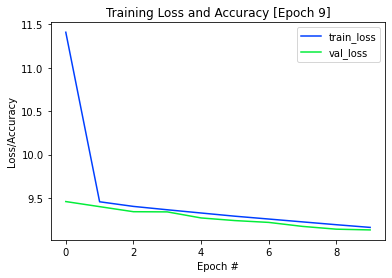

INFO:tensorflow:Assets written to: embed_checkpoint\adam_checkpoint\model.10-9.13\assets


INFO:tensorflow:Assets written to: embed_checkpoint\adam_checkpoint\model.10-9.13\assets


***************************** Stage 1 has run for   251.43170285224915

---------------------------------------------------------
 Starting to train DragonNet stage 2 !!!!!!!!

Batch 81: Invalid loss, terminating training


INFO:tensorflow:Assets written to: embed_checkpoint\sgd_checkpoints\model.01-inf\assets


INFO:tensorflow:Assets written to: embed_checkpoint\sgd_checkpoints\model.01-inf\assets


***************************** DragonNet training has run for  264.5213932991028
average propensity for treated: 0.0 and untreated: 0.0
average propensity for treated: 0.0 and untreated: 0.0


In [6]:
#path to embedding models & checkpoints
embed_model = 'embed_final/'
checkpoint_path = 'embed_checkpoint/'
tf.random.set_seed(101)

test_outputs, train_outputs, dragonnet = train.train_dragonnet_w_embeddings(causal_net_data,
                                                               checkpoint_path,
                                                               embeddings_path=embed_model,
                                                               adam_lr = 1e-5,
                                                               rd_one_epoch=10,
                                                               rd_two_epoch=10)

In [7]:
output_frame = train.unpack(test_outputs, causal_net_data)
output_frame.head()

,q_t0,q_t1,g,t,weight,Area,VehBrand,VehGas,Region,y,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
0,0.0,0.0,0.0,1,0.993812,C,B1,Regular,R82,0.000000,0.0,0.50,7.0,6.0,53.0,50.0,276.0
1,0.0,0.0,0.0,0,0.986525,C,B1,Regular,R53,0.000000,0.0,0.16,7.0,4.0,22.0,85.0,165.0
2,0.0,0.0,0.0,0,1.083502,B,B2,Diesel,R24,0.000000,0.0,1.00,7.0,12.0,50.0,50.0,91.0
3,0.0,0.0,0.0,1,0.999302,D,B6,Diesel,R53,0.000000,0.0,0.75,8.0,5.0,53.0,50.0,644.0
4,0.0,0.0,0.0,1,0.995826,C,B1,Regular,R25,1176.912502,1.0,1.00,7.0,14.0,57.0,50.0,283.0


In [8]:
output_frame.to_csv('data/causalNet_results.csv')